<a href="https://colab.research.google.com/github/IagoMagalhaes23/Geracao-Tech-Unimed-BH_Ciencia-de-Dados/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer-Learning

##Importação das bibliotecas

In [ ]:
import os
import pandas as pd
import numpy as np
import random
import shutil
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import matplotlib.patches as mpatches

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

##Carregando Dataset

In [ ]:
from google.colab import drive #Importação da biblioteca Drive
drive.mount('/content/gdrive') #Cria uma pasta gdrive com arquivos do drive

Mounted at /content/gdrive


##Funções de leitura dos arquivos

In [ ]:
base_dir  = '/content/gdrive/MyDrive/plantas/Agricultural-crops/'
os.chdir(base_dir)

# to list every directory name (label name)
directories_list = tf.io.gfile.listdir(base_dir)

# get number of labels
len_labels = len(directories_list)
print(f"Total Class Labels = {len_labels}")

vis_images = []; vis_labels =[]
length_file_list = []; label_list = []

for item in directories_list:
    
    # get each label directory
    item_dir = os.path.join(base_dir, item)
    # get list of images of each label
    item_files = os.listdir(item)
    # number of images per label
    len_per_label = len(os.listdir(item))
    
    length_file_list.append(len_per_label)
    label_list.append(item)
    
    # get first image of each label (for visualisation purpose)
    vis_images.append(os.path.join(item_dir, item_files[0]))
    # get respective label name (for visualisation purpose)
    vis_labels.append(item)

df_temp = pd.DataFrame({'Labels':label_list, 'Number of Images':length_file_list}).\
sort_values(by='Number of Images', ascending=False)
df_temp

Total Class Labels = 30


,Labels,Number of Images
19,Pearl_millet(bajra),39
26,Tobacco-plant,33
8,cotton,32
3,Cherry,32
15,maize,31
1,banana,31
9,Cucumber,31
29,wheat,31
12,jowar,30
5,clove,30


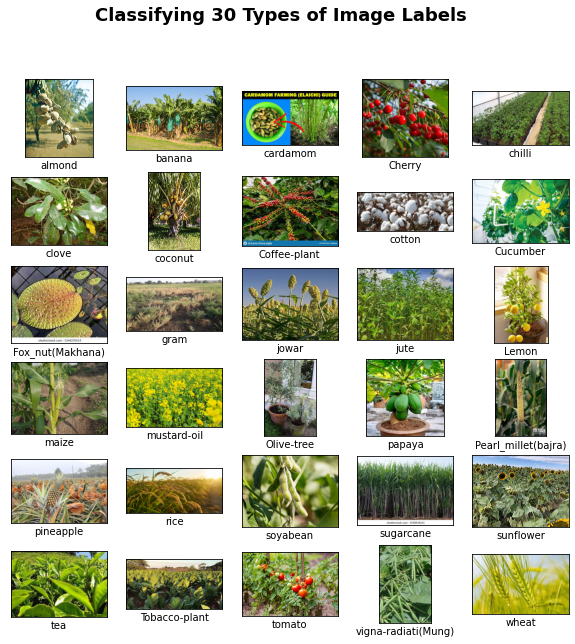

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(vis_labels)):
    plt.subplot(6,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mpimg.imread(vis_images[i])
    plt.imshow(img)
    plt.xlabel(vis_labels[i])
    plt.suptitle(f"Classifying {len_labels} Types of Image Labels",fontsize=18, fontweight='bold')
plt.show()

In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

    selected_file_names = []
    all_file_names = os.listdir(SOURCE_DIR)
    for file_name in all_file_names:
        file_path = os.path.join(SOURCE_DIR, file_name)
        size = os.path.getsize(file_path)
        if size != 0:
              selected_file_names.append(file_name)
        else:
              print(f"{file_name} is zero length, so ignoring.")

    random.seed(42)
    selected_train_files = random.sample(selected_file_names, int(SPLIT_SIZE * len(selected_file_names)))
    selected_val_files = [x for x in selected_file_names if x not in selected_train_files]

    for file_name in selected_train_files:
        source = os.path.join(SOURCE_DIR, file_name)
        destination = os.path.join(TRAINING_DIR, file_name)
        copyfile(source, destination)

    for file_name in selected_val_files:
        source = os.path.join(SOURCE_DIR, file_name)
        destination = os.path.join(VALIDATION_DIR, file_name)
        copyfile(source, destination)

In [ ]:
def create_train_val_dirs(root_path, split_size = 0.9):
    for item in directories_list:
        source_dir = os.path.join(base_dir, item)
        training_dir = os.path.join(root_path, f'_MODELLING/training/{item}')
        validation_dir = os.path.join(root_path, f'_MODELLING/validation/{item}')

        # Create EMPTY directory
        os.makedirs(training_dir)
        os.makedirs(validation_dir)
        
        split_data(source_dir, training_dir, validation_dir, split_size)
    print(f"Created training and validation directories containing images at split size of {split_size}")

In [ ]:
create_train_val_dirs('/kaggle/working', split_size = 0.9)

Created training and validation directories containing images at split size of 0.9


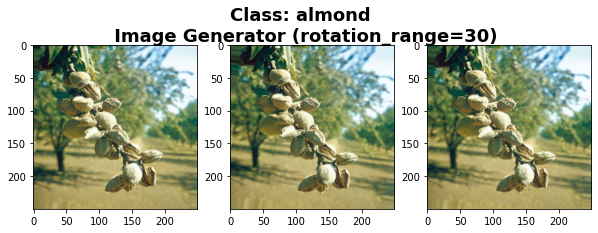

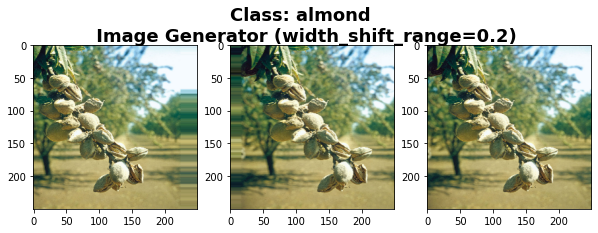

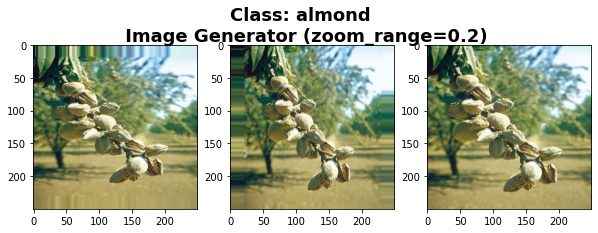

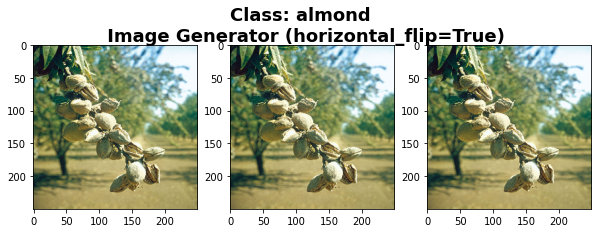

In [ ]:
def show_ImageDataGenerator(vis_images, vis_labels, image_index):
    #Loads image in from the set image path
    class_label = vis_labels[image_index]
    img = tf.keras.preprocessing.image.load_img(vis_images[image_index], target_size= (250,250))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    #Creates our batch of one image
    def show_image(datagen, param):
        pic = datagen.flow(img_tensor, batch_size =1)
        plt.figure(figsize=(10,3.5))
        #Plots our figures
        for i in range(1,4):
            plt.subplot(1, 3, i)
            batch = pic.next()
            image_ = batch[0].astype('uint8')
            plt.imshow(image_)
        plt.suptitle(f"Class: {class_label} \n Image Generator ({param})",fontsize=18, fontweight='bold')

        plt.show()

    datagen = ImageDataGenerator(rotation_range=30)
    show_image(datagen, "rotation_range=30")

    datagen = ImageDataGenerator(width_shift_range=0.2)
    show_image(datagen, "width_shift_range=0.2")

    datagen = ImageDataGenerator(zoom_range=0.2)
    show_image(datagen, "zoom_range=0.2")

    datagen = ImageDataGenerator(horizontal_flip=True)
    show_image(datagen, "horizontal_flip=True")

show_ImageDataGenerator(vis_images, vis_labels, image_index = 0)

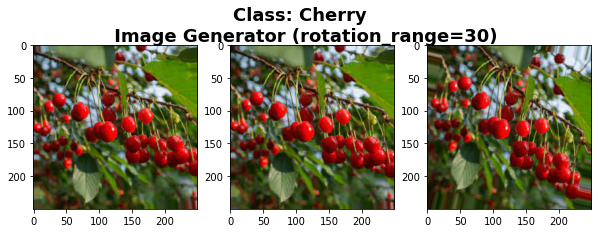

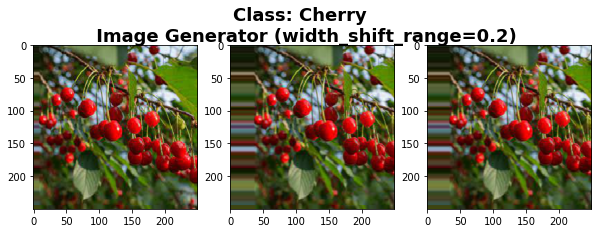

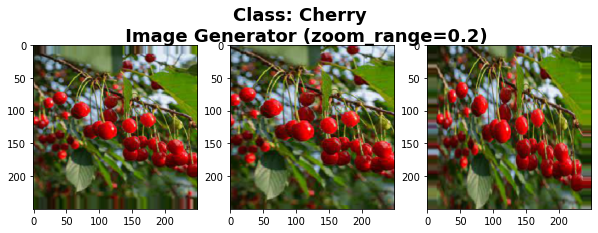

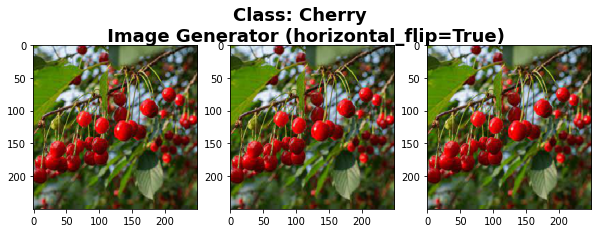

In [ ]:
show_ImageDataGenerator(vis_images, vis_labels, image_index = 3)

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

    # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
    train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    return train_generator, validation_generator

In [ ]:
training_dir = os.path.join('/kaggle/working', '_MODELLING', 'training')
validation_dir = os.path.join('/kaggle/working', '_MODELLING', 'validation')

print(validation_dir)

/kaggle/working/_MODELLING/validation


In [ ]:
train_generator, validation_generator = train_val_generators(training_dir, validation_dir)

Found 731 images belonging to 30 classes.
Found 98 images belonging to 30 classes.


In [ ]:
# build the network
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(len_labels))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                  

In [ ]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    batch_size = 128)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


17/23 [=====================>........] - ETA: 8s - loss: 3.4199 - accuracy: 0.0260 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


23/23 [==============================] - 38s 2s/step - loss: 3.4153 - accuracy: 0.0260 - val_loss: 3.3971 - val_accuracy: 0.0408
Epoch 2/20
23/23 [==============================] - 34s 1s/step - loss: 3.3872 - accuracy: 0.0479 - val_loss: 3.3765 - val_accuracy: 0.0612
Epoch 3/20
23/23 [==============================] - 43s 2s/step - loss: 3.3284 - accuracy: 0.0766 - val_loss: 3.2946 - val_accuracy: 0.0510
Epoch 4/20
23/23 [==============================] - 39s 2s/step - loss: 3.2415 - accuracy: 0.0793 - val_loss: 3.2152 - val_accuracy: 0.0816
Epoch 5/20
23/23 [==============================] - 33s 1s/step - loss: 3.1595 - accuracy: 0.0930 - val_loss: 3.0705 - val_accuracy: 0.1327
Epoch 6/20
23/23 [==============================] - 33s 1s/step - loss: 3.0426 - accuracy: 0.1245 - val_loss: 3.0311 - val_accuracy: 0.1122
Epoch 7/20
23/23 [==============================] - 31s 1s/step - loss: 2.9606 - accuracy: 0.1573 - val_loss: 2.9003 - val_accuracy: 0.1122
Epoch 8/20
23/23 [=============

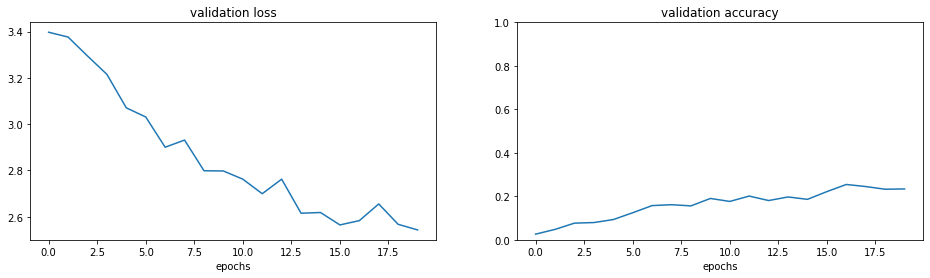

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [ ]:
validation_generator

In [ ]:
loss, accuracy = model.evaluate(validation_generator, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 2.543065071105957
Test accuracy: 0.19387754797935486


In [ ]:
from tensorflow.keras.applications import VGG16

vgg =  VGG16(weights='imagenet', include_top=True)
vgg.summary()

553476096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(len_labels, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


In [ ]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.8):
            print("\nReached 80% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

In [ ]:
from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(include_top=False,weights='imagenet', input_shape=(150, 150, 3))
for layer in pre_trained_model.layers:
    layer.trainable = False
    
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

58900480/58889256 [==============================] - 1s 0us/step
There are 14,714,688 total parameters in this model.
There are 0 trainable parameters in this model.


In [ ]:
last_output = pre_trained_model.output
print('last layer output: ', last_output)

# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")
The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [ ]:
from tensorflow.keras import Model
def transfer_learning(last_output, pre_trained_model):
    # Flatten the output layer to 1 dimension
    x = tf.keras.layers.Flatten()(last_output)
    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.3
    x = tf.keras.layers.Dropout(0.3)(x)  
    # Add a final sigmoid layer for classification
    x = tf.keras.layers.Dense(len_labels, activation='softmax')(x)          
    # Create the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)
    
    return model

In [ ]:
model_2 = transfer_learning(last_output, pre_trained_model)
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [ ]:
model_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
history_2 = model_2.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 20,
                    callbacks=callbacks)

Epoch 1/20
 7/23 [========>.....................] - ETA: 2:33 - loss: 4.8513 - accuracy: 0.0502

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


23/23 [==============================] - 233s 10s/step - loss: 3.9226 - accuracy: 0.0958 - val_loss: 2.7633 - val_accuracy: 0.2041
Epoch 2/20
23/23 [==============================] - 202s 9s/step - loss: 2.7586 - accuracy: 0.2490 - val_loss: 2.3193 - val_accuracy: 0.3469
Epoch 3/20
23/23 [==============================] - 200s 9s/step - loss: 2.3798 - accuracy: 0.3420 - val_loss: 2.2622 - val_accuracy: 0.3469
Epoch 4/20
23/23 [==============================] - 203s 9s/step - loss: 2.1626 - accuracy: 0.3762 - val_loss: 2.0490 - val_accuracy: 0.4388
Epoch 5/20
23/23 [==============================] - 204s 9s/step - loss: 1.9577 - accuracy: 0.4405 - val_loss: 1.8705 - val_accuracy: 0.5408
Epoch 6/20
23/23 [==============================] - 208s 9s/step - loss: 1.7672 - accuracy: 0.4884 - val_loss: 1.9458 - val_accuracy: 0.4592
Epoch 7/20
23/23 [==============================] - 201s 9s/step - loss: 1.7549 - accuracy: 0.4884 - val_loss: 1.8101 - val_accuracy: 0.5408
Epoch 8/20
23/23 [=====

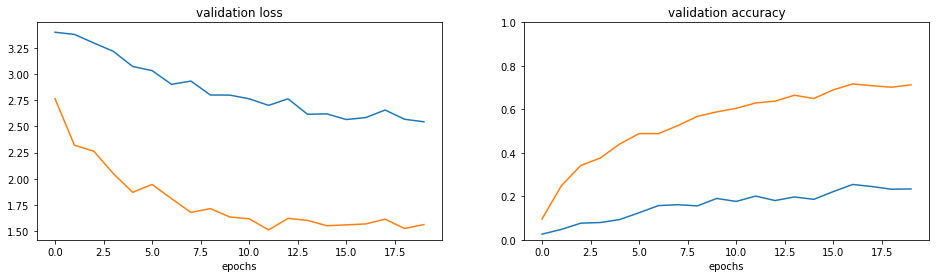

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history_2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"])
ax2.plot(history_2.history["accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [ ]:
loss, accuracy = model_2.evaluate(validation_generator, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.562760353088379
Test accuracy: 0.6326530575752258


In [ ]:
def get_image(path):
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [ ]:
img, x = get_image('/content/gdrive/MyDrive/plantas/Agricultural-crops/Lemon/image14.jpeg')
probabilities = model_2.predict([x])
print(probabilities)

[[2.3250717e-28 6.5737254e-35 0.0000000e+00 0.0000000e+00 6.6989479e-08
  0.0000000e+00 0.0000000e+00 0.0000000e+00 8.7592299e-24 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.9944082e-36
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0352921e-14 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 9.9999988e-01 0.0000000e+00 0.0000000e+00]]
